In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m

tfd=tfp.distributions

In [2]:
def draw(points,ax = None,R = 100):
    ## function to plot the geometry
    if ax == None:
        f,ax=plt.subplots()
    x = points[:,0]
    z = points[:,1]
    for i in range(points.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'r-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)
    
pi = tf.constant(m.pi) # define PI in Tensorflow form

In [3]:
depth = -20
thickness = 20

corners=np.array([[-200,depth-thickness],
                  [-70,depth-thickness],
                  [70,depth-thickness],# bottom left coner
              [200,depth-thickness], 
              [200,depth], # bottom right coner
              [70, depth], # top right coner
              [-70,depth],# top left coner
              [-200,depth]])
N = 2
obs_N = 9
points = np.empty((2*N+8,2),dtype = np.float32)

points[0] = corners[0]
points[1] = corners[1]

for i in range(6):
    points[N+i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(21)

x2 = np.linspace(-70,70,N+2)
x1 = np.linspace(70,-70,N+2)

thickness = 20
y1 = np.random.uniform(-2,-50,N)
y2 = y1-thickness

y1 = list(reversed(y1))

for i in range(2,N+2): ## lower layer
    points[i][1] = y2[i-2]
    points[i][0] = x2[i-1]
    
for i in range(N+6,2*N+6): ## upper layer
    points[i][1] = y1[i-N-6]
    points[i][0] = x1[i-N-5]


(-70, 70)

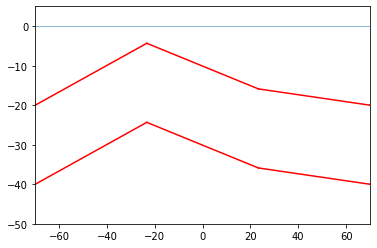

In [4]:
f,ax=plt.subplots()
x = points[:,0]
z = points[:,1]
for i in range(points.shape[0]):
    ax.plot(x[i:i+2],z[i:i+2],'r-')
x_ = np.linspace(-70,70,10)
ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
ax.set_ylim(min(points[:,1])-10,5)
ax.set_xlim(-70,70)


#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [39]:
@tf.function
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

@tf.function
def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

@tf.function
def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)

@tf.function
def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))

@tf.function
def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(data,loc):
    
    ''' 
    data: Points defining the geometry 2N+coners
    loc: reference point (2x1)
    
    '''
    
    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_data.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(points,ps):
    """
    points: base point, fixing the x position
    ps: Positions,Variable(N elements vector), tuning z position
    
    """
    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    N1 = tf.constant(N)
    ps2 = ps-t

    ps2 = tf.reverse(ps2,[-1])

    for i in tf.range(2,N1+2): ## lower layer
        points[i].assign([points[i][0],ps2[i-2]])

    for i in tf.range(N1+6,2*N1+6): ## upper layer
        points[i].assign([points[i][0],ps[i-N1-6]])

    x_obv = tf.linspace(-70., 70., obs_N+2)
    y_obv = tf.zeros(tf.shape(x_obv))
    obv = tf.stack((x_obv,y_obv),axis = 1)


    gravity = tf.TensorArray(tf.float32, size=obv.shape[0]-2)
    
    j = tf.constant(0)
    for i in obv[1:-1]:
        gravity=gravity.write(j,-g(points,i))
        j = tf.add(j,1)
    return gravity.stack()


def joint_log_prob(D,points_copy,ps):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    low_ = tf.constant(-40.)
    high_ = tf.constant(-1.)
    mvn_prior = tfd.Uniform(
            low = low_,
            high = high_)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(tf.reduce_sum(mvn_prior.log_prob(ps))
          +mvn_likelihood.log_prob(D))


In [40]:
low_ = tf.constant(-40.)
high_ = tf.constant(-1.)
mvn_prior = tfd.Uniform(
        low = low_,
        high = high_)
ps = [-2,-2]
mvn_prior.log_prob(ps)


<tf.Tensor: id=484408, shape=(2,), dtype=float32, numpy=array([-3.6635616, -3.6635616], dtype=float32)>

In [41]:
mu_prior = -20.*tf.ones([50],dtype = tf.float32)
cov_prior = 20.*tf.eye(N)

sig_e = 0.0000003
cov = sig_e**2*tf.eye(obs_N)

In [42]:
points = tf.Variable(points,dtype = tf.float32)

In [43]:
# define the ground truth
True_position = tf.constant([-5.,-10.,])
obs_data = grav(points,True_position)

In [44]:
D = obs_data

In [45]:
joint_log_prob(D,points,tf.constant([-5.,-10]))

<tf.Tensor: id=487878, shape=(), dtype=float32, numpy=119.57778>

#### Gradient decent

In [46]:
mu = tf.Variable([-1.,-12]) # initial parameters
for i in range(100):
    with tf.GradientTape() as t:  
        t.watch(points)
        loss = tf.negative(joint_log_prob(D,points,mu)) # negative log posterior
        dlossdmu = t.gradient(loss,points)
        d = tf.stack([dlossdmu[8][1],dlossdmu[9][1]])
        mu = mu - 0.1 *d
        MAP = mu
print(MAP)

tf.Tensor([ -4.9995136 -10.00102  ], shape=(2,), dtype=float32)


### The above looks correct so far, the problem is the second derivative

In [47]:
with tf.GradientTape() as t:  
    t.watch(points)
    loss = tf.negative(joint_log_prob(D,points,mu)) # negative log posterior
    dlossdmu = t.gradient(loss,points)
    print(dlossdmu)

tf.Tensor(
[[ 1.9749276e-04  6.1382467e-05]
 [-3.6544268e-05  3.1182231e-04]
 [-6.9311776e-05  4.1504219e-04]
 [-4.1349944e-05 -8.3810592e-05]
 [-2.7052229e-05 -1.3547788e-04]
 [-1.9707759e-04 -1.4638422e-05]
 [ 1.9749267e-04  1.0913356e-05]
 [ 5.4485623e-05  2.1765514e-04]
 [ 1.0876888e-04  3.8692309e-04]
 [ 1.2978839e-04 -7.9220888e-04]
 [ 4.9968130e-05 -3.3474411e-04]
 [-1.9114149e-04 -3.6288682e-05]], shape=(12, 2), dtype=float32)


In [48]:
with tf.GradientTape() as t:
    with tf.GradientTape() as tt:
        tt.watch(points)
        loss = tf.negative(joint_log_prob(D,points,mu))
    jacobian = tt.gradient(loss,points)
hess = t.gradient(jacobian,points)

In [49]:
hess

<tf.Tensor: id=3482592, shape=(12, 2), dtype=float32, numpy=
array([[-0.52794534, -0.04220943],
       [ 0.01333523, -0.13357821],
       [ 0.0407761 , -0.2905235 ],
       [-0.06953196, -0.5919126 ],
       [-0.07488035, -0.44090396],
       [ 0.5386223 , -0.09564582],
       [-0.5279453 ,  0.0558771 ],
       [ 0.10361256,  0.47201908],
       [ 0.13986973,  0.9219442 ],
       [-0.0353485 ,  0.27279344],
       [-0.00623425,  0.06563071],
       [ 0.5219386 ,  0.02184391]], dtype=float32)>